## Analisis next100 in IC

### This notebook performs two tasks:
1. reads nexus files and performs energy smearing, voxelization and fidicialization to write output in hdf5 file format
2. read back file from 1. to make tracks and perform standard analysis

### <u> Energy Smearing </u> : $ ~~~~ E_{tot} \to E'_{tot}$, obtain ratio $F = E'_{tot}/E_{tot}$

The smearing takes into account that the energy resolution at the $Q_{\beta\beta}$ is 0.75% FWHM; 

and the relation that the resolution as a function of E follows:  $1/\sqrt(E)$ from $\frac{\sigma(E)}{E} = \frac{a}{\sqrt E}$, where $a$ is the stochastic term

Inputs: 1) energy resolution in % and FWHM at $Q_{\beta\beta}$, 2) energy of the event $E$

Steps: 

 a) obtain resolution at the given energy: $\sigma$       (FWHM = $2 ~ \sqrt{2~ ln ~ 2}~ \sigma$ )

 b) build a Gaussian function with $\mu$ energy of the event and $\sigma$ obtained in a) ---> TODO: gaussian 0 ,1 
       
 c) obtain $E'_{tot}$ from the Gaussian in in **b)**
 
 
 
 ### Function:
     1. fwhm_at_Qvalue in %
     2. event_energy in MeV
     3. sigma_at_Qvalue and sigma_at_event_energy adimensional
     4. returns smear_energy adimensional from a Gaussian centered in 1 and sigma sigma_at_event_energy



In [1]:
from collections import namedtuple

smearing = namedtuple("Smearing", ['factor', 'energy'])

def fwhm_at_event_energy (fwhm_at_Qvalue, event_energy):
    Qvalue = 2.458
    fwhm_at_event_energy = fwhm_at_Qvalue * np.sqrt(Qvalue) / np.sqrt(event_energy)
    return fwhm_at_event_energy

def smeared_energy ( fwhm_at_Qvalue, event_energy ):
    fwhm   = fwhm_at_event_energy (fwhm_at_Qvalue, event_energy)
    sigma  = fwhm / (100 * 2 * np.sqrt(2*np.log(2)))
    smearing_factor = np.random.normal( 1 ,sigma)
    event_energy_smear = event_energy * smearing_factor
    return smearing(factor = smearing_factor, energy = event_energy_smear)

#### Smearing of voxels:     $~~~~~E'_{vox}= E_{vox}/E_{tot} \times E'_{tot}$



In [2]:
def smeared_energy_voxel (evoxel, etot, e_smear ):
    return evoxel * e_smear / etot   

### <u> Fiducial cut </u>:   
exclude a region of <font color=red> **20 mm** </font> around the boundaries of the active volume, a) for the smear voxel and b) for the original voxel

Exclude events with voxels located in the vetoed region with energy above **10 keV** (the detection threshold of the tracking plane)

Dimensions of next100 detector: **anodePos, cathodePos, radius =  (0., 1300., 534.5)** mm

### $x^2+y^2 < 534.5-fid$

### Next100 nexus test input file:

In [3]:
input_files = "/Users/neus/current-work/tonne-work/nexus-files-next100/tl/Tl208*-.next.h5"
!ls /Users/neus/current-work/tonne-work/nexus-files-next100/tl/Tl208*-.next.h5

/Users/neus/current-work/tonne-work/nexus-files-next100/tl/Tl208-000-.next.h5
/Users/neus/current-work/tonne-work/nexus-files-next100/tl/Tl208-001-.next.h5
/Users/neus/current-work/tonne-work/nexus-files-next100/tl/Tl208-002-.next.h5
/Users/neus/current-work/tonne-work/nexus-files-next100/tl/Tl208-003-.next.h5
/Users/neus/current-work/tonne-work/nexus-files-next100/tl/Tl208-004-.next.h5
/Users/neus/current-work/tonne-work/nexus-files-next100/tl/Tl208-005-.next.h5
/Users/neus/current-work/tonne-work/nexus-files-next100/tl/Tl208-006-.next.h5
/Users/neus/current-work/tonne-work/nexus-files-next100/tl/Tl208-007-.next.h5
/Users/neus/current-work/tonne-work/nexus-files-next100/tl/Tl208-008-.next.h5
/Users/neus/current-work/tonne-work/nexus-files-next100/tl/Tl208-009-.next.h5
/Users/neus/current-work/tonne-work/nexus-files-next100/tl/Tl208-010-.next.h5
/Users/neus/current-work/tonne-work/nexus-files-next100/tl/Tl208-011-.next.h5
/Users/neus/current-work/tonne-work/nexus-files-next100/tl/Tl208

### Imports:

In [4]:
import sys
import os
import shutil
import functools
import time
import glob

%matplotlib inline
print("Running on ", time.asctime())

import numpy             as np
import tables            as tb
import matplotlib.pyplot as plt
from   matplotlib.colors import LogNorm
import pandas as pd

Running on  Thu Oct 25 18:14:33 2018


In [5]:
import platform
platform.python_version()

'3.6.6'

In [6]:
from invisible_cities.icaro.hst_functions import hist
from invisible_cities.icaro.hst_functions import hist2d
from invisible_cities.icaro.hst_functions import pdf
from invisible_cities.icaro.hst_functions import labels
from invisible_cities.icaro.hst_functions import display_matrix
from invisible_cities.icaro.hst_functions import covariance
from invisible_cities.icaro.hst_functions import resolution
from invisible_cities.icaro.hst_functions import gausstext
from invisible_cities.icaro.hst_functions import shift_to_bin_centers
from invisible_cities.icaro.hst_functions import plot_writer
from invisible_cities.icaro.hst_functions import measurement_string

from invisible_cities.icaro.mpl_functions import plt_scatter3d,plt_scatter2d


In [7]:
from networkx                   import Graph
from invisible_cities.evm.event_model         import Voxel
from invisible_cities.evm.event_model         import VoxelCollection
from invisible_cities.core.exceptions         import NoHits
from invisible_cities.core.exceptions         import NoVoxels
from invisible_cities.evm.event_model         import MCHit
from invisible_cities.evm.event_model         import BHit
from invisible_cities.evm.event_model         import Voxel
from invisible_cities.evm.event_model         import Track
from invisible_cities.evm.event_model         import Blob
from invisible_cities.evm.event_model         import TrackCollection
from invisible_cities.core.system_of_units_c  import units

from invisible_cities.reco.paolina_functions  import *
from invisible_cities.io.mcinfo_io            import *

from invisible_cities.reco import tbl_functions as tbl

### Build hdf5 output: (missing: add table with production info)

In [8]:
class VoxelsTable(tb.IsDescription):
    event    = tb.  Int32Col(pos=0)
    time     = tb.Float64Col(pos=1)
    energy   = tb.Float64Col(pos=2)
    energyS  = tb.Float64Col(pos=3)
    X        = tb.Float64Col(pos=4)
    Y        = tb.Float64Col(pos=5) 
    Z        = tb.Float64Col(pos=6)
    E_v      = tb.Float64Col(pos=7)
    ES_v     = tb.Float64Col(pos=8)
    Etot_v   = tb.Float64Col(pos=9)
    EStot_v  = tb.Float64Col(pos=10)


In [9]:
output_file = "/Users/neus/current-work/tonne-work/nexus-files-next100/voxels/voxels-tl.h5"
FILTERS = tb.Filters(complib='zlib', complevel=4)
h5file = tb.open_file(output_file, 'w', filters=FILTERS, title = "Voxels file") 
group = h5file.create_group("/", 'events', 'Voxels information')
table = h5file.create_table(group, 'voxels', VoxelsTable, "voxels")
row = table.row

### Read mc hits from nexus:
0. use function *load_mchits* to get a dictionary whose keys are ID_number and values are a list of MCHit (from the IC Event Model)
1. smear energy
2. voxelize
3. fiducialize 
4. write hdf5 file containing a table with variables: eventID, X, Y, Z, E

In [10]:
# cuts (energies in MeV, dimensions in mm)
emin      = 2.4 
emax      = 2.5
tpc_radius = 534.5 
fid_cut    = 20.0
fid        = tpc_radius - fid_cut
zmin       = 0. + fid_cut
zmax       = 1200.0 - fid_cut 
 
# parameters
voxel_dim    = np.array([10,10,10]) # mm

# counters
evtot = 0
c_Es_smear      = 0
c_fid           = 0


for input_file in glob.glob(input_files):
    
    print(input_file)
    events =  load_mchits(input_file)
    evtot = evtot + len(events)
    for evID, hits in events.items():
        fiducial_cut     = False 
        Es = sum(hit.E for hit in hits)
        Es_smear = smeared_energy(0.75, Es).energy
        
        if( emin < Es_smear < emax ):
            c_Es_smear += 1
            voxels = voxelize_hits(hits,voxel_dim) 
            totE_voxel  = sum(voxel.E for voxel in voxels)
            totES_voxel = sum(smeared_energy_voxel (voxel.E, Es, Es_smear ) for voxel in voxels)
            for voxel in voxels:
                if( (np.sqrt( voxel.X**2 + voxel.Y**2) < fid ) and zmin < voxel.Z < zmax ):
                    fiducial_cut = True
                    row["event" ]  = evID
                    row["time"  ]  = 0.
                    row["energy"]  = Es
                    row["energyS"] = Es_smear
                    row["X"     ]  = voxel.X
                    row["Y"     ]  = voxel.Y
                    row["Z"     ]  = voxel.Z
                    row["E_v"]     = voxel.E
                    row["ES_v"]    = smeared_energy_voxel (voxel.E, Es, Es_smear )
                    row["Etot_v"]  = totE_voxel
                    row["EStot_v"] = totES_voxel
                    row.append()
                else: 
                    break                    
        else: 
            continue

        if ( fiducial_cut )     : c_fid            += 1

table.flush()  
h5file.close()
        
print("+++++++-------------------------------------------------+++++++\n")
print("Total events analized =                      = " + str(evtot))
print("Events passing energy smearing cut           = " + str(c_Es_smear))
print("Events passing fiducial cut                  = " + str(c_fid))
print("\n")     
print("+++++++-------------------------------------------------+++++++")


/Users/neus/current-work/tonne-work/nexus-files-next100/tl/Tl208-002-.next.h5
/Users/neus/current-work/tonne-work/nexus-files-next100/tl/Tl208-003-.next.h5
/Users/neus/current-work/tonne-work/nexus-files-next100/tl/Tl208-036-.next.h5
/Users/neus/current-work/tonne-work/nexus-files-next100/tl/Tl208-037-.next.h5
/Users/neus/current-work/tonne-work/nexus-files-next100/tl/Tl208-008-.next.h5
/Users/neus/current-work/tonne-work/nexus-files-next100/tl/Tl208-009-.next.h5
/Users/neus/current-work/tonne-work/nexus-files-next100/tl/Tl208-014-.next.h5
/Users/neus/current-work/tonne-work/nexus-files-next100/tl/Tl208-021-.next.h5
/Users/neus/current-work/tonne-work/nexus-files-next100/tl/Tl208-020-.next.h5
/Users/neus/current-work/tonne-work/nexus-files-next100/tl/Tl208-012-.next.h5
/Users/neus/current-work/tonne-work/nexus-files-next100/tl/Tl208-013-.next.h5
/Users/neus/current-work/tonne-work/nexus-files-next100/tl/Tl208-026-.next.h5
/Users/neus/current-work/tonne-work/nexus-files-next100/tl/Tl208

### Read back the pytable using DataFrames

In [11]:
intable = tb.open_file(output_file,mode='r')
to_df = pd.DataFrame.from_records
data = to_df(intable.root.events.voxels.read())
data.head(10)
#data

,event,time,energy,energyS,X,Y,Z,E_v,ES_v,Etot_v,EStot_v
0,6000,0.0,2.457826,2.46602,93.740481,-403.702566,395.701962,0.336849,0.337972,2.457826,2.46602
1,6000,0.0,2.457826,2.46602,93.740481,-403.702566,405.675953,0.587630,0.589589,2.457826,2.46602
2,6000,0.0,2.457826,2.46602,93.740481,-403.702566,415.649944,0.134258,0.134705,2.457826,2.46602
3,6000,0.0,2.457826,2.46602,93.740481,-393.762787,395.701962,0.072757,0.072999,2.457826,2.46602
4,6000,0.0,2.457826,2.46602,93.740481,-393.762787,405.675953,0.126024,0.126445,2.457826,2.46602
5,6000,0.0,2.457826,2.46602,102.562767,-403.702566,395.701962,0.610715,0.612751,2.457826,2.46602
6,6000,0.0,2.457826,2.46602,102.562767,-403.702566,405.675953,0.119594,0.119993,2.457826,2.46602
7,6000,0.0,2.457826,2.46602,102.562767,-403.702566,415.649944,0.130392,0.130827,2.457826,2.46602
8,6000,0.0,2.457826,2.46602,102.562767,-393.762787,405.675953,0.030820,0.030923,2.457826,2.46602
9,6000,0.0,2.457826,2.46602,146.674195,-383.823008,704.895695,0.034556,0.034671,2.457826,2.46602


In [12]:
events = data['event'].unique().tolist()
#print(min(events)," to ",max(events))
len(events)

6126

In [13]:
type(data)

pandas.core.frame.DataFrame

In [14]:
#events

In [15]:
energies               = data['energy'] .values
energies_Smear         = data['energyS'].values
voxel_energies         = data['E_v']    .values
voxel_energies_Smear   = data['ES_v']   .values
v_x                    = data['X']      .values
v_y                    = data['Y']      .values
v_z                    = data['Z']      .values
tot_energies_v         = data['Etot_v'] .values
tot_energies_Smear_v   = data['EStot_v'].values


Text(0.5, 0, 'voxels energy - voxels energy smeared (MeV)')

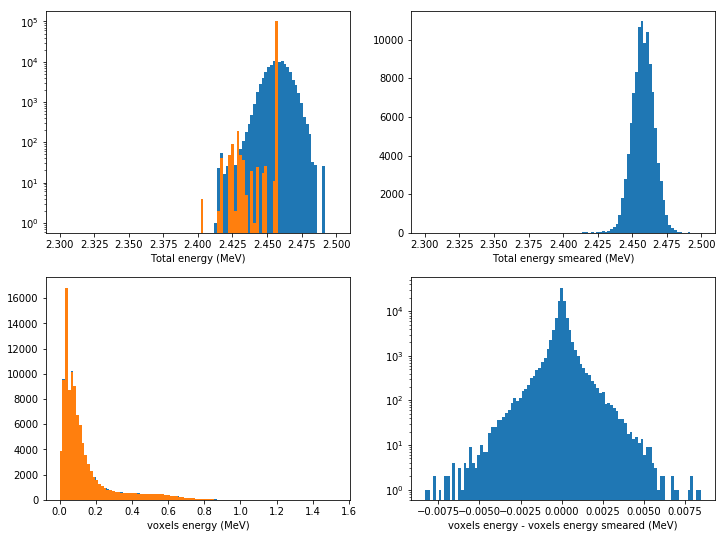

In [16]:
fig = plt.figure(figsize = (12,9))
bins = 100

ax1 = fig.add_subplot(2,2,1)
plt.hist(energies_Smear,bins,[2.3,2.5])
plt.hist(energies,100,[2.3,2.5])
plt.yscale('log', nonposy='clip')
plt.xlabel('Total energy (MeV)')

ax2 = fig.add_subplot(2,2,2)
plt.hist(energies_Smear,bins,[2.3,2.5])
plt.xlabel('Total energy smeared (MeV)')


ax3 = fig.add_subplot(2,2,3)
plt.hist(voxel_energies_Smear, bins, stacked=True)
plt.hist(voxel_energies, bins, stacked=True, )
plt.xlabel('voxels energy (MeV)')


ax4 = fig.add_subplot(2,2,4)
plt.yscale('log', nonposy='clip')
plt.hist( voxel_energies - voxel_energies_Smear , bins)
plt.xlabel('voxels energy - voxels energy smeared (MeV)')



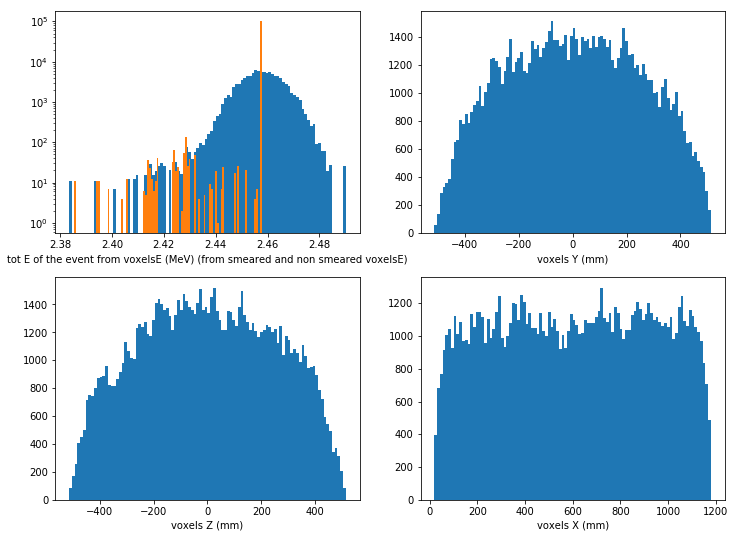

In [17]:
bins = 100

fig = plt.figure(figsize = (12,9))

ax1 = fig.add_subplot(2,2,1)
plt.hist(tot_energies_Smear_v,bins)
plt.hist(tot_energies_v, bins)
plt.yscale('log', nonposy='clip')
plt.xlabel('tot E of the event from voxelsE (MeV) (from smeared and non smeared voxelsE)')

ax2 = fig.add_subplot(2,2,2)
plt.hist(v_x, bins)
plt.xlabel('voxels Y (mm)')

ax3 = fig.add_subplot(2,2,3)
plt.hist(v_y, bins)
plt.xlabel('voxels Z (mm)')

ax1 = fig.add_subplot(2,2,4)
plt.hist(v_z, bins)
plt.xlabel('voxels X (mm)')

plt.show()



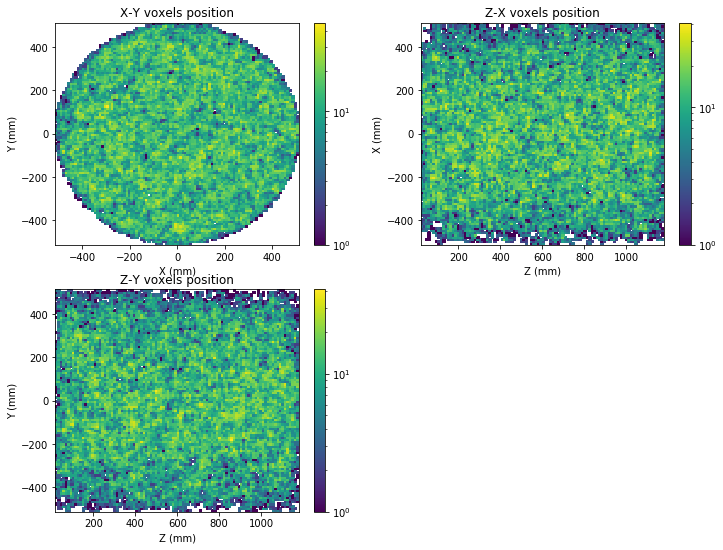

In [18]:
bins = 100

fig = plt.figure(figsize = (12,9))
ax1 = fig.add_subplot(2,2,1)
plt.hist2d(v_x, v_y, bins, norm=LogNorm())
plt.colorbar()
plt.title('X-Y voxels position')
plt.xlabel('X (mm)')
plt.ylabel('Y (mm)')


ax2 = fig.add_subplot(2,2,2)
plt.hist2d(v_z, v_x, bins, norm=LogNorm())
plt.colorbar()
plt.title('Z-X voxels position')
plt.xlabel('Z (mm)')
plt.ylabel('X (mm)')

ax3 = fig.add_subplot(2,2,3)
ax3.hist2d(v_z, v_y, bins, norm=LogNorm())
plt.colorbar()
plt.title('Z-Y voxels position')
plt.xlabel('Z (mm)')
plt.ylabel('Y (mm)')
plt.show()



In [19]:
intable

File(filename=voxels.h5, title='Voxels file', mode='r', root_uep='/', filters=Filters(complevel=4, complib='zlib', shuffle=True, bitshuffle=False, fletcher32=False, least_significant_digit=None))
/ (RootGroup) 'Voxels file'
/events (Group) 'Voxels information'
/events/voxels (Table(105406,), shuffle, zlib(4)) 'voxels'
  description := {
  "event": Int32Col(shape=(), dflt=0, pos=0),
  "time": Float64Col(shape=(), dflt=0.0, pos=1),
  "energy": Float64Col(shape=(), dflt=0.0, pos=2),
  "energyS": Float64Col(shape=(), dflt=0.0, pos=3),
  "X": Float64Col(shape=(), dflt=0.0, pos=4),
  "Y": Float64Col(shape=(), dflt=0.0, pos=5),
  "Z": Float64Col(shape=(), dflt=0.0, pos=6),
  "E_v": Float64Col(shape=(), dflt=0.0, pos=7),
  "ES_v": Float64Col(shape=(), dflt=0.0, pos=8),
  "Etot_v": Float64Col(shape=(), dflt=0.0, pos=9),
  "EStot_v": Float64Col(shape=(), dflt=0.0, pos=10)}
  byteorder := 'little'
  chunkshape := (780,)

In [20]:
to_df = pd.DataFrame.from_records
data = to_df(intable.root.events.voxels.read())
data.head(40)

,event,time,energy,energyS,X,Y,Z,E_v,ES_v,Etot_v,EStot_v
0,6000,0.0,2.457826,2.466020,93.740481,-403.702566,395.701962,0.336849,0.337972,2.457826,2.466020
1,6000,0.0,2.457826,2.466020,93.740481,-403.702566,405.675953,0.587630,0.589589,2.457826,2.466020
2,6000,0.0,2.457826,2.466020,93.740481,-403.702566,415.649944,0.134258,0.134705,2.457826,2.466020
3,6000,0.0,2.457826,2.466020,93.740481,-393.762787,395.701962,0.072757,0.072999,2.457826,2.466020
4,6000,0.0,2.457826,2.466020,93.740481,-393.762787,405.675953,0.126024,0.126445,2.457826,2.466020
5,6000,0.0,2.457826,2.466020,102.562767,-403.702566,395.701962,0.610715,0.612751,2.457826,2.466020
6,6000,0.0,2.457826,2.466020,102.562767,-403.702566,405.675953,0.119594,0.119993,2.457826,2.466020
7,6000,0.0,2.457826,2.466020,102.562767,-403.702566,415.649944,0.130392,0.130827,2.457826,2.466020
8,6000,0.0,2.457826,2.466020,102.562767,-393.762787,405.675953,0.030820,0.030923,2.457826,2.466020
9,6000,0.0,2.457826,2.466020,146.674195,-383.823008,704.895695,0.034556,0.034671,2.457826,2.466020


### Tracks:


**make_tracks** ( 
                
                evt_number       : float,

                evt_time         : float,
                
                voxels           : List[Voxel],
                
                voxel_dimensions : np.ndarray,
                
                contiguity       : float = 1,
                
                blob_radius      : float = 30 * units.mm) 

In [21]:
events = data['event'].unique().tolist()

In [22]:
len(events)

6126

In [23]:
# cuts (energies in MeV, dimensions in mm)
trk_minE   = 0.003  # not used
blob_minE  = 0.3 
emin      =  2.453 
emax      =  2.475
# parameters


lnum_trk   = []
ltrk_E     = []
lblob1_E   = []
lblob2_E   = []

# counters
ev_tot = 0
c_single_track  = 0
c_trk_minE      = 0
c_blob_minE     = 0

# lists for plotting (will be changed by writting an hdf5 specific for plotting)
lnum_trk   = []
ltrk_E     = []
lblob1_E   = []
lblob2_E   = []



ev_tot = 0

for ev in events:
    single_track_cut = False 
    trk_minE_cut     = False
    blob_minE_cut    = False
    ev_tot += 1
    ev_data = data[data['event'].isin([ev])]
    vx =  ev_data['X'].tolist()
    vy =  ev_data['Y'].tolist()
    vz =  ev_data['Z'].tolist()
    ve =  ev_data['ES_v'].tolist()
    posE = list(zip(vx,vy,vz,ve))
    voxels = [ Voxel(pos[0], pos[1], pos[2], pos[3], voxel_dim) for pos in posE]
    trks = make_tracks(ev, 2, voxels, voxel_dim, 18, 15)
    if (trks.number_of_tracks == 1):
        single_track_cut = True
        lnum_trk.append(trks.number_of_tracks)                    
        for trk in trks.tracks:
            if(trk.blobs[0].E > blob_minE and trk.blobs[1].E > blob_minE ):
                blob_minE_cut = True
                lblob1_E.append(trk.blobs[0].E)
                lblob2_E.append(trk.blobs[1].E)
                if ( emin < trk.E < emax):
                    trk_minE_cut = True
                    ltrk_E.append(trk.E)

    if ( single_track_cut ) : c_single_track   += 1
    if ( trk_minE_cut )     : c_trk_minE       += 1
    if ( blob_minE_cut)     : c_blob_minE      += 1

print("+++++++-------------------------------------------------+++++++")
print("Total events analized                        = " + str(ev_tot))
print("Events passing single track                  = " + str(c_single_track))
print("Events passing energy track cut              = " + str(c_trk_minE))
print("Events passing energy blob min energy cut    = " + str(c_blob_minE))
#print("Efficiency = "+c_blob_minE/ev_tot +" %")
print("\n")     
print("+++++++-------------------------------------------------+++++++")

print("Running on ", time.asctime())


num_trk = np.array(lnum_trk)
trk_E   = np.array(ltrk_E)
blob1_E = np.array(lblob1_E)
blob2_E = np.array(lblob2_E)

+++++++-------------------------------------------------+++++++
Total events analized                        = 6126
Events passing single track                  = 4600
Events passing energy track cut              = 2647
Events passing energy blob min energy cut    = 3778


+++++++-------------------------------------------------+++++++
Running on  Thu Oct 25 18:12:06 2018


Text(0.5, 0, 'number of tracks per event')

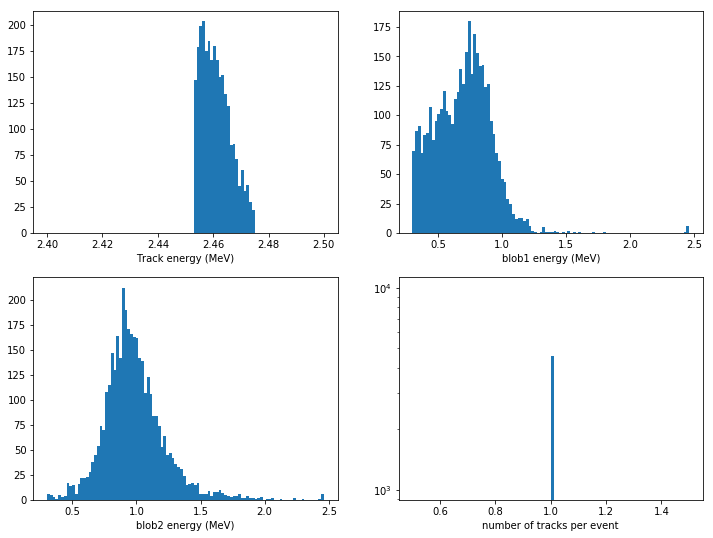

In [24]:
bins = 100
#w = v_E - v_E_smear

fig = plt.figure(figsize = (12,9))

ax1 = fig.add_subplot(2,2,1)
plt.hist(trk_E,100,[2.4,2.5])
plt.xlabel('Track energy (MeV)')

ax2 = fig.add_subplot(2,2,2)
plt.hist(blob1_E,100)
plt.xlabel('blob1 energy (MeV)')


ax3 = fig.add_subplot(2,2,3)
plt.hist(blob2_E, bins, stacked=True)
plt.xlabel('blob2 energy (MeV)')


ax4 = fig.add_subplot(2,2,4)
plt.yscale('log', nonposy='clip')
plt.hist( num_trk, bins )
plt.xlabel('number of tracks per event')



Text(0, 0.5, 'e2')

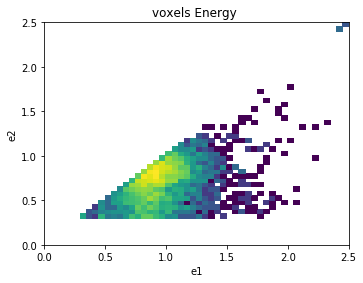

In [25]:
bins = 50 

fig = plt.figure(figsize = (12,9))
ax1 = fig.add_subplot(2,2,1)
plt.hist2d(blob2_E, blob1_E, bins, [[0.0, 2.5], [0.0, 2.5]] , norm=LogNorm())
#plt.colorbar()
plt.title('voxels Energy ')
plt.xlabel('e1')
plt.ylabel('e2')

